In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train[y_train == 5]
y_train = y_train[y_train == 5]

In [4]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

In [5]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]

In [6]:
x_train = x_train / 255
x_test = x_test / 255

In [7]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
hidden_dim = 2

In [12]:
generator = tf.keras.Sequential([
    
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)), #7x7
  BatchNormalization(),
    
  Reshape((7, 7, 256)),
    
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
    
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'), #14x14
  BatchNormalization(),
    
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'), #28x28
    
])

In [13]:
discriminator = tf.keras.Sequential([

Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
LeakyReLU(),
Dropout(0.3),

Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
LeakyReLU(),
Dropout(0.3),

Flatten(),
Dense(1)

])

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

In [16]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True) # generate img

    real_output = discriminator(images, training=True) # gradient of real in disc
    fake_output = discriminator(generated_images, training=True) # gradient of generated in disc

    gen_loss = generator_loss(fake_output) # loss of generation 
    disc_loss = discriminator_loss(real_output, fake_output) # loss of discriminator

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # calculate gradients 
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) 

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # apply optimizer 
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [32]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))

  return history

In [33]:
EPOCHS = 80
history = train(train_dataset, EPOCHS)

1/80: ===========: tf.Tensor(3.1128068, shape=(), dtype=float32)
2/80: ===========: tf.Tensor(3.267565, shape=(), dtype=float32)
3/80: ===========: tf.Tensor(3.2347658, shape=(), dtype=float32)
4/80: ===========: tf.Tensor(3.1459959, shape=(), dtype=float32)
5/80: ===========: tf.Tensor(2.6888418, shape=(), dtype=float32)
6/80: ===========: tf.Tensor(2.8511527, shape=(), dtype=float32)
7/80: ===========: tf.Tensor(1.7152481, shape=(), dtype=float32)
8/80: ===========: tf.Tensor(1.5428016, shape=(), dtype=float32)
9/80: ===========: tf.Tensor(1.657714, shape=(), dtype=float32)
10/80: ===========: tf.Tensor(1.4855903, shape=(), dtype=float32)
11/80: ===========: tf.Tensor(1.5245483, shape=(), dtype=float32)
12/80: ===========: tf.Tensor(1.3447152, shape=(), dtype=float32)
13/80: ===========: tf.Tensor(1.3476104, shape=(), dtype=float32)
14/80: ===========: tf.Tensor(1.4193305, shape=(), dtype=float32)
15/80: ===========: tf.Tensor(1.1656079, shape=(), dtype=float32)
16/80: ===========: t

1/1 [==============================] - 0s 24ms/step


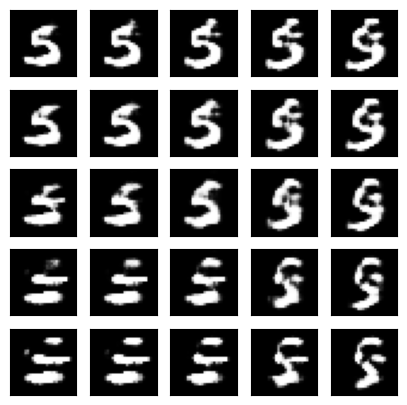

In [34]:
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()